<a href="https://colab.research.google.com/github/KevinYih/BigDataDemo/blob/main/Copy_of_PageRank_Random_Walk_MovieLens_by_Kevin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PageRank
Adapted from: https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/pagerank.ipynb

In [1]:
import urllib.request
data = urllib.request.urlopen("https://raw.githubusercontent.com/chandan-u/graph-based-recommendation-system/master/data/movies.csv").read()
with open("./movies.csv", "wb") as f:
  f.write(data)
data = urllib.request.urlopen("https://raw.githubusercontent.com/chandan-u/graph-based-recommendation-system/master/data/ratings.csv").read()
with open("./ratings.csv", "wb") as f:
  f.write(data)


In [2]:
import pandas as  pd
import numpy as np
import networkx as nx

def load_movielens():
    """
         load the three csv files:
             1. movies.csv: movieId,title,genres
             2. ratings.csv: userId,movieId,rating,timestamp
             3. tags.csv: userId,movieId,tag,timestamp   ( This is not needed for now)
    """
    movies = pd.read_csv('./movies.csv', sep=',')
    ratings = pd.read_csv('./ratings.csv', sep=',')
    return movies, ratings

def biparteGraph(movies_frame, ratings_frame):
    """
       convert the movies data frame into userid-movies biparte adjacency graph matrix
    """
    B = nx.Graph()
    user_ids = list(ratings_frame.userId.unique())
    movie_ids = list(movies_frame.movieId.unique())
    print("number of users:", len(user_ids))
    print("number of movies:", len(movie_ids))

    #B.add_nodes_from(user_ids, bipartite="user ids")
    #B.add_nodes_from(movie_ids, bipartite="movie ids")
    # initialize a numpy matrix of of numberOfUsers * numberOfMovies
    for name, group in ratings_frame.groupby(["userId", "movieId"]):
        # name is a tuple (userId, movieId)
        userId, movieId = name
        m = movies[movies.movieId == movieId].title
        title = m[m.index[0]]
        #rating = group[["rating"]].values[0,0]
        B.add_edge(f"user:{userId}", title)

    return B


# load csv into dataframes
movies, ratings  = load_movielens()
# convert the ratings datafrom into user-movie biparte graph
B = biparteGraph(movies, ratings)

number of users: 671
number of movies: 9125


In [3]:
B.number_of_edges(), B.number_of_nodes()

(100003, 9735)

In [4]:
list(B.nodes)[:10]

['user:1',
 'Dangerous Minds (1995)',
 'Dumbo (1941)',
 'Sleepers (1996)',
 'Escape from New York (1981)',
 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)',
 'Deer Hunter, The (1978)',
 'Ben-Hur (1959)',
 'Gandhi (1982)',
 "Dracula (Bram Stoker's Dracula) (1992)"]

In [5]:
B['user:73']

AtlasView({'Toy Story (1995)': {}, 'Jumanji (1995)': {}, 'Heat (1995)': {}, 'GoldenEye (1995)': {}, 'Cutthroat Island (1995)': {}, 'Casino (1995)': {}, 'Ace Ventura: When Nature Calls (1995)': {}, 'Get Shorty (1995)': {}, 'Leaving Las Vegas (1995)': {}, 'Dangerous Minds (1995)': {}, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': {}, 'Babe (1995)': {}, 'Dead Man Walking (1995)': {}, 'Clueless (1995)': {}, 'Mortal Kombat (1995)': {}, 'Seven (a.k.a. Se7en) (1995)': {}, 'Pocahontas (1995)': {}, 'Usual Suspects, The (1995)': {}, 'Indian in the Cupboard, The (1995)': {}, "Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)": {}, 'Bio-Dome (1996)': {}, 'Friday (1995)': {}, 'From Dusk Till Dawn (1996)': {}, 'Shopping (1994)': {}, 'Bottle Rocket (1996)': {}, 'Happy Gilmore (1996)': {}, 'Muppet Treasure Island (1996)': {}, 'Braveheart (1995)': {}, 'Taxi Driver (1976)': {}, 'Rumble in the Bronx (Hont faan kui) (1995)': {}, 'Bad Boys (1995)': {}, 'Basketball Diaries, The 

In [6]:
def get_node_neighbors_subgraph(G, node, frac=.1):
    neighbors = set(list(G.neighbors(node))[:int(frac*len(list(G.neighbors(node))))])
    neighbors_of_neighbors = set()
    for neighbor in neighbors:
        neighbors_of_neighbors.update(list(G.neighbors(neighbor))[:int(frac*len(list(G.neighbors(neighbor))))])

    # Combine the node, its neighbors, and their neighbors into a single set
    nodes_to_draw = neighbors  | {node} | neighbors_of_neighbors

    # Create a subgraph containing only the nodes of interest
    subgraph = G.subgraph(nodes_to_draw)

    return subgraph

Here's what the graph looks like. Multiple links appear as slightly thicker lines.

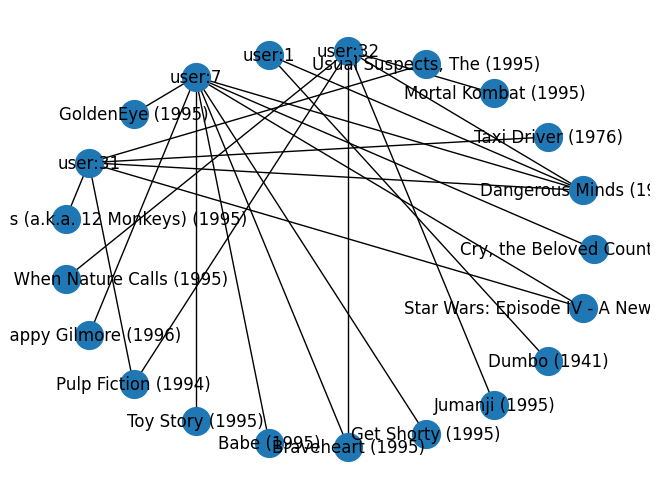

In [7]:
def draw_graph(G):
    nx.draw_circular(G, node_size=400, with_labels=True)

sub = get_node_neighbors_subgraph(B, 'Dangerous Minds (1995)', frac=.1)

draw_graph(sub)

NetworkX provides an implementation of PageRank we can use to compute a metric of "importance" for each page.

In [8]:
ranks_pr = nx.pagerank(B)
sorted(ranks_pr.items(), key=lambda x: -x[1])[:10]

[('user:547', 0.019686487233840862),
 ('user:624', 0.012712654175352927),
 ('user:564', 0.010500410058924225),
 ('user:73', 0.009318370110549118),
 ('user:15', 0.008984741244518472),
 ('user:468', 0.007248032226058771),
 ('user:452', 0.006901500779023015),
 ('user:311', 0.005500921986154309),
 ('user:380', 0.005485733047023199),
 ('user:30', 0.005401881837438508)]

You should see that nodes with more in-links get higher scores.

##  Random Walk

One way to interpret PageRank is in terms of a random walk.
Suppose you choose a node at random, then choose one of its out-links at random, and continue like that, making a note of each node you visit.

If a node has a lot of in-links, you are likely to visit it more often.
And if those in-links come from nodes with many in-links, even more so.

However, there is one catch: if a node contains no out-links, or if a set of nodes form a loop with no out-links, the random walker could get trapped.

To avoid that, we'll modify the random walk so at every step there is some probability that the walker jumps to a random node rather than following a link.
This probability is determined by a parameter, `alpha`, which is the probability of following a link, so `1-alpha` is the probability of making a random jump.

The following function implements a random walk, with these random jumps, and uses a `Counter` to keep track of the number of times it visits each node.

It returns the `Counter` with the frequencies normalized to add up to one.
If everything goes according to plan, these values should approximate the results from PageRank.

In [9]:
import numpy as np

def flip(p):
    return np.random.random() < p

In [10]:
from collections import Counter

def random_walk(G, alpha=0.85, iters=1000000):
    counter = Counter()
    node = next(iter(G))

    for _ in range(iters):
        if flip(alpha):
            node = np.random.choice(list(G[node]))
        else:
            node = np.random.choice(list(G))

        counter[node] += 1

    total = sum(counter.values())
    for key in counter:
        counter[key] /= total
    return counter

The default value of `alpha` is 0.85, which is the same as the default value for `nx.pagerank`.

Here are the scores we get from the random walk.

In [12]:

ranks_rw = random_walk(B, iters=10000)
sorted(ranks_rw.items(), key=lambda x: -x[1])[:10]

[('user:547', 0.0185),
 ('user:624', 0.0123),
 ('user:564', 0.0096),
 ('user:73', 0.009),
 ('user:15', 0.0089),
 ('user:452', 0.0075),
 ('user:468', 0.0069),
 ('user:311', 0.006),
 ('user:213', 0.0059),
 ('user:294', 0.0059)]

To compare them to the results from PageRank, put them in a Pandas `DataFrame`.

In [16]:
import pandas as pd

s1 = pd.Series(ranks_pr)
s2 = pd.Series(ranks_rw)

df = pd.DataFrame(dict(PageRank=s1, RandomWalk=s2))
df['Diff'] = df['RandomWalk'] - df['PageRank']
df*100

,PageRank,RandomWalk,Diff
"""Great Performances"" Cats (1998)",0.002524,NaN,NaN
$9.99 (2008),0.002963,0.01,0.007037
'Hellboy': The Seeds of Creation (2004),0.001862,NaN,NaN
'Neath the Arizona Skies (1934),0.002028,NaN,NaN
'Round Midnight (1986),0.002732,0.01,0.007268
...,...,...,...
xXx (2002),0.011142,NaN,NaN
xXx: State of the Union (2005),0.001979,NaN,NaN
¡Three Amigos! (1986),0.014174,0.04,0.025826
À nous la liberté (Freedom for Us) (1931),0.002040,0.01,0.007960


Why some of the entries are `NaN`?, does it help if you increase the value of `iters`

In [ ]:
# 1) why for `iters=10000` the RandomWalk value for some nodes is undefined?
# 2) If you want to measure the error rate between `PageRank` and `RandomWalk`,
# what would be a sensible formula for that? compute the error rate for:
# iters = 10000, 100000, 200000, 1000000
# 3) Explain how PageRank values should be interpreted in this context?
# 4) Look at top rank movies and users, and justify that your answer to
# the previous question makes sense.


In [ ]:
# 1) why for `iters=10000` the RandomWalk value for some nodes is undefined?

# Because:

# Random walks do not visit all nodes.
# The random walk algorithm is based on probability, and especially when the number of iterations (iters) is small, some nodes may never be visited during the random walk.
# Even though iters=10000 seems to be a large number, in a large graph structure, this number of iterations may not be enough to cover all nodes.

# Structural characteristics of the graph.
# If there are isolated nodes in the graph (i.e. nodes with no incoming or outgoing edges), these nodes may never be visited during the random walk, resulting in their scores being NaN.
# In addition, if there are some "dead ends" or "islands" in the graph, the nodes in these areas may also not be easily visited by the random walk.

# Initial node selection and jump probability.
# The initial node selection and jump probability (alpha) of the random walk may affect the probability of some nodes being visited.
# If the initial node selection is uneven or the jump probability is set unreasonably, some nodes may be visited less or not visited at all.

In [26]:
# 2) If you want to measure the error rate between `PageRank` and `RandomWalk`,
# what would be a sensible formula for that? compute the error rate for:
# iters = 10000, 100000, 200000, 1000000

# I would like use Mean Absolute Error(MAE) to compute the error rate.

ranks_rw1 = random_walk(B, iters=10000)
ranks_rw2 = random_walk(B, iters=100000)
ranks_rw3 = random_walk(B, iters=200000)
ranks_rw4 = random_walk(B, iters=1000000)

# transfer PageRank and RandomWalk to Pandas Series
s1 = pd.Series(ranks_pr)
s_rw1 = pd.Series(ranks_rw1)
s_rw2 = pd.Series(ranks_rw2)
s_rw3 = pd.Series(ranks_rw3)
s_rw4 = pd.Series(ranks_rw4)

# compute the error rate(Mean Absolute Error, MAE) for PageRank and each RandomWalk
mae1 = (s1 - s_rw1).abs().mean()
mae2 = (s1 - s_rw2).abs().mean()
mae3 = (s1 - s_rw3).abs().mean()
mae4 = (s1 - s_rw4).abs().mean()

print(f"MAE between PageRank and RandomWalk (10000 iterations): {mae1}")
print(f"MAE between PageRank and RandomWalk (100000 iterations): {mae2}")
print(f"MAE between PageRank and RandomWalk (200000 iterations): {mae3}")
print(f"MAE between PageRank and RandomWalk (1000000 iterations): {mae4}")

MAE between PageRank and RandomWalk (10000 iterations): 0.00010357359911316909
MAE between PageRank and RandomWalk (100000 iterations): 1.9850833451044326e-05
MAE between PageRank and RandomWalk (200000 iterations): 1.3932352453367681e-05
MAE between PageRank and RandomWalk (1000000 iterations): 6.323988317066576e-06


In [ ]:
# 3) Explain how PageRank values should be interpreted in this context?

# PageRank of User Nodes:
# High PageRank Users: A user node with a high PageRank value indicates that this user has rated or watched many important movies or is connected to many influential users.
# This suggests that the user plays a significant role in the movie community, possibly because their tastes align well with the community's overall preferences.

# Low PageRank Users: A user node with a low PageRank value indicates that this user has rated or watched fewer important movies or is influenced by fewer important users.
# This may suggest that the user has less influence within the community or their movie preferences are less aligned with the majority.


# PageRank of Movie Nodes:
# High PageRank Movies: A movie node with a high PageRank value indicates that this movie has been rated or watched by many users, especially those who are influential.
# This suggests that the movie is highly popular or well-regarded within the user community.

# Low PageRank Movies: A movie node with a low PageRank value indicates that this movie has been rated or watched by fewer users or by users who are less influential.
# This may suggest that the movie is less popular or has lower ratings within the community.

In [25]:
# 4) Look at top rank movies and users, and justify that your answer to
# the previous question makes sense.

ranks_pr = nx.pagerank(B)

# Extract the PageRank values ​​of user nodes and movie nodes respectively
user_ranks = {node: rank for node, rank in ranks_pr.items() if node.startswith('user:')}
movie_ranks = {node: rank for node, rank in ranks_pr.items() if not node.startswith('user:')}

# top 10 user nodes.
top_10_users = sorted(user_ranks.items(), key=lambda x: -x[1])[:10]
print("Top 10 users by PageRank:")
for user, rank in top_10_users:
    print(f"{user}: {rank}")

# top 10 movie nodes.
top_10_movies = sorted(movie_ranks.items(), key=lambda x: -x[1])[:10]
print("\nTop 10 movies by PageRank:")
for movie, rank in top_10_movies:
    print(f"{movie}: {rank}")

Top 10 users by PageRank:
user:547: 0.019686487233840862
user:624: 0.012712654175352927
user:564: 0.010500410058924225
user:73: 0.009318370110549118
user:15: 0.008984741244518472
user:468: 0.007248032226058771
user:452: 0.006901500779023015
user:311: 0.005500921986154309
user:380: 0.005485733047023199
user:30: 0.005401881837438508

Top 10 movies by PageRank:
Forrest Gump (1994): 0.0012203737648493055
Pulp Fiction (1994): 0.001162867878628815
Shawshank Redemption, The (1994): 0.001120085040874431
Silence of the Lambs, The (1991): 0.0010947030875432296
Star Wars: Episode IV - A New Hope (1977): 0.0010562076672594664
Matrix, The (1999): 0.0009734161744864054
Jurassic Park (1993): 0.0009643237209085636
Toy Story (1995): 0.0008978442182958
Schindler's List (1993): 0.0008766085005408053
Star Wars: Episode V - The Empire Strikes Back (1980): 0.0008623896451247884


In [31]:
import random

def random_walk_with_teleport_S(G, alpha=0.85, iters=3000000, S=None):
# 5) implement the random walk with a teleport S. Use it to find
# similar movies to your favorite set of movies.
    if S is None:
        raise ValueError("传送节点集合 S 不能为空")

    # initiate the counter
    visits = {node: 0 for node in G.nodes()}

    # initiate the start pointer randomly.
    current_node = random.choice(list(G.nodes()))

    for _ in range(iters):
        if random.random() < alpha:
            # Teleport to a random node in S with probability alpha
            current_node = random.choice(S)
        else:
            # Otherwise, perform a random walk along the edges of the graph.
            neighbors = list(G.neighbors(current_node))
            if neighbors:
                current_node = random.choice(neighbors)
            else:
                # If the current node has no neighbors, randomly select a new node
                current_node = random.choice(list(G.nodes()))

        # record the visit
        visits[current_node] += 1

    # compute the visiting rate.
    total_visits = sum(visits.values())
    visit_probabilities = {node: count / total_visits for node, count in visits.items()}

    return visit_probabilities

def find_similar_movies(G, favorite_movies, alpha=0.85, iters=300000):
    # perform  random_walk with teletransport
    visit_probabilities = random_walk_with_teleport_S(G, alpha=alpha, iters=iters, S=favorite_movies)

    # Consider only movie nodes and exclude the most liked movies, sorted by access probability
    similar_movies = sorted(
        (node for node in visit_probabilities if node not in favorite_movies and not node.startswith('user:')),
        key=lambda node: visit_probabilities[node],
        reverse=True
    )

    return similar_movies

# user_favourite movie list.
favorite_movies = ['Dangerous Minds (1995)', 'Dumbo (1941)']

# find similar movies
similar_movies = find_similar_movies(B, favorite_movies, alpha=0.85, iters=300000)

print("Similar movies to your favorite movies:")
for movie in similar_movies[:10]:
    print(movie)

Similar movies to your favorite movies:
Jurassic Park (1993)
Aladdin (1992)
Beauty and the Beast (1991)
Shawshank Redemption, The (1994)
Bridges of Madison County, The (1995)
Pulp Fiction (1994)
Mask, The (1994)
Stargate (1994)
Apollo 13 (1995)
Lion King, The (1994)


In [34]:
# 6) biparteGraph function only uses the existence of a
#    rating to establish a link. Change it so that it uses the rating
#    as the weight of the edge.

def biparteGraph(movies_frame, ratings_frame):
    B = nx.Graph()
    user_ids = list(ratings_frame.userId.unique())
    movie_ids = list(movies_frame.movieId.unique())
    print("number of users:", len(user_ids))
    print("number of movies:", len(movie_ids))

    #B.add_nodes_from(user_ids, bipartite="user ids")
    #B.add_nodes_from(movie_ids, bipartite="movie ids")
    # initialize a numpy matrix of of numberOfUsers * numberOfMovies
    for name, group in ratings_frame.groupby(["userId", "movieId"]):
        # name is a tuple (userId, movieId)
        userId, movieId = name
        m = movies[movies.movieId == movieId].title
        title = m[m.index[0]]
        B.add_edge(f"user:{userId}", title, weight=rating)  # uses the rating as the weight of the edge.

    return B

In [36]:
def weighted_random_walk_with_teleport_S(G, alpha=0.85, iters=1000000, S=None):
# 7) the current implementation of random walk only relies on the existence of a
#    rating and ignores the value. Use the value to implement
#.   a weighted version of the random walk. Use the weighted version
#    to find similar movies and compare the results.


    # initiate the counter
    node_count = {node: 0 for node in G.nodes()}

    # initiate the start pointer randomly.
    if S is None:
        current_node = random.choice(list(G.nodes()))
    else:
        current_node = random.choice(list(S))

    for _ in range(iters):
        if random.random() < alpha:
            # Teleport to a random node in S with probability alpha
            if S is None:
                current_node = random.choice(list(G.nodes()))
            else:
                current_node = random.choice(list(S))
        else:
            # Weighted selection of next node
            neighbors = list(G.neighbors(current_node))
            if neighbors:
                weights = [G[current_node][neighbor]['weight'] for neighbor in neighbors]
                total_weight = sum(weights)
                probabilities = [weight / total_weight for weight in weights]
                current_node = random.choices(neighbors, probabilities)[0]

        # record the visit
        node_count[current_node] += 1

    # compute node access probability
    node_prob = {node: count / iters for node, count in node_count.items()}

    return node_prob